In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

from scipy.interpolate import interp1d, make_smoothing_spline

from astropy import units as u

mpl.rc('font', family='serif', size=16)

In [2]:
import jax
import equinox as eqx
from tinygp.helpers import JAXArray

jax.config.update("jax_enable_x64", True)

In [3]:
def dateformat(ax):
    locator   = mpl.dates.AutoDateLocator()
    formatter = mpl.dates.ConciseDateFormatter(locator)
    ax.xaxis.set_major_locator(locator)
    ax.xaxis.set_major_formatter(formatter)

In [4]:
def histogram_residuals(mu_ss, mu_gp, var_ss, var_gp):
    fig, (ax1, ax2) = plt.subplots(1,2,figsize=(8,3), sharey=True)
    ax1.hist(mu_ss-mu_gp)
    ax2.hist(var_ss-var_gp)
    ax1.set(xlabel=r'$\mu_{ss} - \mu_{gp}$', )
    ax2.set(xlabel=r'$\sigma^2_{ss} - \sigma^2_{gp}$');
    fig.tight_layout()
    return fig, (ax1, ax2)

In [5]:
import jax
import jax.numpy as jnp
from jax.scipy.linalg import expm, solve

key = jax.random.PRNGKey(0)

In [6]:
import tinygp
import smolgp

# Benchmarking

In [ ]:
from benchmark import *
from plotting import *

In [8]:
np.array([f'{n:.1e}' for n in jnp.logspace(1,7,17)])

array(['1.0e+01', '2.4e+01', '5.6e+01', '1.3e+02', '3.2e+02', '7.5e+02',
       '1.8e+03', '4.2e+03', '1.0e+04', '2.4e+04', '5.6e+04', '1.3e+05',
       '3.2e+05', '7.5e+05', '1.8e+06', '4.2e+06', '1.0e+07'], dtype='<U7')

In [9]:
import glob
import pickle

def load_from_individual(func):
    result = {'Ns': [], 'runtime': {}, 'memory': {}, 'outputs': {}}
    funcs = {'SSM': f'ss_{func}', 'QSM': f'qs_{func}', 'GP': f'gp_{func}'}

    for name in ['SSM', 'QSM', 'GP']:
        funcname = funcs[name]
        filenames = np.array(glob.glob(f'results/individual/{funcname}_*.pkl'))
        Ns = np.array([f.split('_')[-1].split('.pkl')[0] for f in filenames]).astype(float)
        idx = np.argsort(Ns)
        result['Ns'] = Ns[idx]
        for f in filenames[idx]:
            with open(f, 'rb') as file:
                d = pickle.load(file)
            for key in ['runtime', 'memory']:
                if name not in result[key]:
                    result[key][name] = []
                result[key][name].append(*d[key][name])

    return result

# Plot layout

In [13]:
mpl.rc("font", **{"family": "serif", "serif": ["Computer Modern"]})
mpl.rc("text", usetex=True)
mpl.rcParams["axes.formatter.useoffset"] = False

plt.rcParams['text.usetex'] = True
plt.rcParams['lines.markeredgewidth'] = 1.5
plt.rcParams['lines.markersize'] = 8
plt.rcParams['lines.markeredgecolor'] = 'k'
plt.rcParams['lines.linewidth'] = 2

In [14]:
# mpl.rc("font", **{"family": "sans serif"})
# mpl.rc("text", usetex=False)
# mpl.rcParams["axes.formatter.useoffset"] = False
# plt.rcParams['text.usetex'] = False
# plt.rcParams['lines.markeredgewidth'] = 1.5
# plt.rcParams['lines.markersize'] = 8
# plt.rcParams['lines.markeredgecolor'] = 'k'
# plt.rcParams['lines.linewidth'] = 3

In [15]:
def scale_ext(Next, Ns, runtime_arr, ref=-1, power=1):
    runtimes = np.array([rt[0] for rt in runtime_arr])
    cutnan = ~np.isnan(runtimes)
    runtimes = runtimes[cutnan]
    last_runtime = runtimes[ref]
    last_N = np.array(Ns)[cutnan][ref]
    return last_runtime * (Next / last_N)**power

In [16]:
def residuals_plot(Ns, outputs, label='X'):
    val_ssm = jnp.array(outputs['SSM'])
    val_qsm = jnp.array(outputs['QSM'])
    val_gp  = jnp.array(outputs['GP'])

    res_qs_ss = (val_ssm - val_qsm)
    res_qs_gp = (val_gp - val_qsm)
    res_ss_gp = (val_ssm - val_gp)

    fig, rax = plt.subplots(1,1, figsize=(6,2), sharex=True)
    rax.plot(Ns, res_qs_gp, ls='-',  label=f'${label}'+r'_{GP}$ - '+f'${label}'+r'_{QSM}$')
    rax.plot(Ns, res_qs_ss, ls='--', label=f'${label}'+r'_{SSM}$ - '+f'${label}'+r'_{QSM}$')
    rax.plot(Ns, res_ss_gp, ls=':',  label=f'${label}'+r'_{SSM}$ - '+f'${label}'+r'_{GP}$')
    rax.set(xscale='log', xlabel='Number of data points', ylabel='Residual');
    rax.legend(ncol=3, bbox_to_anchor=(0.5, 1), handletextpad=0.1, loc='lower center', fontsize=12);
    rax.set_yscale('symlog', linthresh=1e-16); rax.grid(lw=0.5, zorder=-1)
    rax.set_yticks(symlogticks(-9, -9, linthresh=1e-16, spacing=3))
    return fig, rax

In [30]:
def hide_yticklabels(ax, which='both'):
    labels = ax.get_yticklabels()
    for i, lbl in enumerate(labels):
        if (which == 'even' and i % 2 == 0) or (which == 'odd' and i % 2 == 1):
            lbl.set_visible(False)

In [54]:
def benchmark_plot(Ns, runtime, memory, labels=None, title=None, savefig=None, **kwargs):
    
    fig, (ax1, ax2) = plt.subplots(2,1, figsize=(5,6.6), sharex=True, 
                                gridspec_kw={'height_ratios':[3,1.5], 'hspace':0.05})

    # Benchmark times
    ax1 = plot_benchmark(Ns, runtime, labels=labels, ax=ax1, **kwargs)# savefig=savefig)
    ax1.legend(loc='upper left', title=title)
    # ax1.set_title(title)
    ax1.yaxis.set_major_locator(mpl.ticker.LogLocator(base=10.0, numticks=10))
    ax1.yaxis.set_minor_locator(mpl.ticker.LogLocator(base=10.0, subs=jnp.arange(1, 10)*0.1, numticks=100))
    ax1.yaxis.set_minor_formatter(mpl.ticker.NullFormatter())

    # Memory usage
    ax1.set_xlabel('')
    ax2 = plot_benchmark(Ns, memory,  ax=ax2, scale=False, labels=labels)# savefig=savefig)
    ax2.get_legend().remove()
    ax2.yaxis.set_major_locator(mpl.ticker.LogLocator(base=10.0, numticks=10))
    ax2.yaxis.set_minor_locator(mpl.ticker.LogLocator(base=10.0, subs=jnp.arange(1, 10)*0.1, numticks=100))
    ax2.yaxis.set_minor_formatter(mpl.ticker.NullFormatter())
    ax2.set_ylabel('Memory [B]');
    ax2.set_xlim(left=Ns[0], right=Ns[-1])
    if savefig:
        plt.savefig(savefig, dpi=300, bbox_inches='tight');

    return fig, (ax1, ax2)

## Likelihood

In [55]:
cpu_llh_filename = 'results/cpu_llh_benchmark.pkl' 
gpu_llh_filename = 'results/gpu_llh_benchmark.pkl'

In [56]:
# Load benchmark results
cpu_llh = load_benchmark_data(cpu_llh_filename)
gpu_llh = load_benchmark_data(gpu_llh_filename)

In [57]:
## Merge the CPU and GPU benchmark results
llh = {key: cpu_llh[key] for key in cpu_llh} # quick copy

for d in ['runtime', 'memory']:
# for d in ['runtime']:
    llh[d]['pSSM'] = gpu_llh[d]['pSSM']
Ns, runtime_llh, memory_llh, outputs_llh = llh['Ns'], llh['runtime'], llh['memory'], llh['outputs']

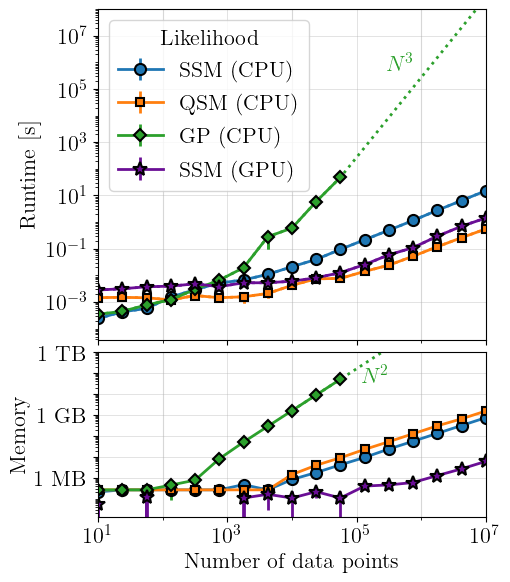

In [58]:
fig, (ax1, ax2) = benchmark_plot(Ns, runtime_llh, memory_llh, title='Likelihood',
                                 labels={"SSM": "SSM (CPU)", 
                                         "QSM": "QSM (CPU)", 
                                         "GP": "GP (CPU)", 
                                         "pSSM": "SSM (GPU)"})
Next = jnp.logspace(6,8,10)
# ax1.plot(Next, scale_ext(Next, Ns, runtime_llh['GP'], ref=-1, power=3), ls=':', color=colors['GP'], label='O(N^3)');
ax1.set_ylim(top=1e8);
ax1.grid(lw=0.5, zorder=-1, which='major')
ax1.annotate("$N^3$", xy=(3e5, 2e6), color=colors['GP'], ha='left', va='top', xycoords='data', fontsize=16)
# hide_yticklabels(ax1, which='even')

# ax1.plot(Ns, jnp.array(gpu_data['runtime']['SSM']).T[0], ls='--')
# ax1.plot(Ns, jnp.array(gpu_data['runtime']['QSM']).T[0], ls='--')
# ax1.plot(Ns, jnp.array(gpu_data['runtime']['GP']).T[0], ls='--')

Next = jnp.logspace(4,8,10)
ax2.plot(Next, scale_ext(Next, Ns, memory_llh['GP'], ref=-1, power=2), ls=':', color=colors['GP'], label='O(N^2)');
ax2.set_yticks([1e6, 1e7, 1e8, 1e9, 1e10, 1e11, 1e12], labels=['1 MB', '', '', '1 GB', '', '', '1 TB']); ax2.set_ylabel('Memory')
ax2.grid(lw=0.5, zorder=-1, which='major')
ax2.annotate("$N^2$", xy=(1.2e5, 2e11), color=colors['GP'], ha='left', va='top', xycoords='data', fontsize=16)
ax2.set_ylim(top=1e12);

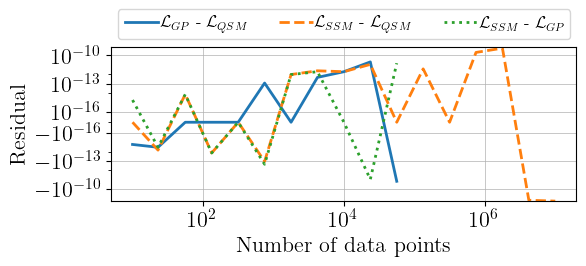

In [53]:
fig, rax = residuals_plot(Ns, outputs_llh, label=r'\mathcal{L}')

## Conditioning at the data points

In [52]:
cpu_cond_filename = 'results/cpu_cond_benchmark.pkl'
gpu_cond_filename = 'results/gpu_cond_benchmark.pkl'

cpu_cond = load_benchmark_data(cpu_cond_filename)
gpu_cond = load_benchmark_data(gpu_cond_filename)

In [53]:
## Merge the CPU and GPU benchmark results
cond = {key: cpu_cond[key] for key in cpu_cond} # quick copy

for d in ['runtime', 'memory']:
# for d in ['runtime']:
    cond[d]['pSSM'] = gpu_cond[d]['pSSM']
Ns, runtime_cond, memory_cond, outputs_cond = cond['Ns'], cond['runtime'], cond['memory'], cond['outputs']

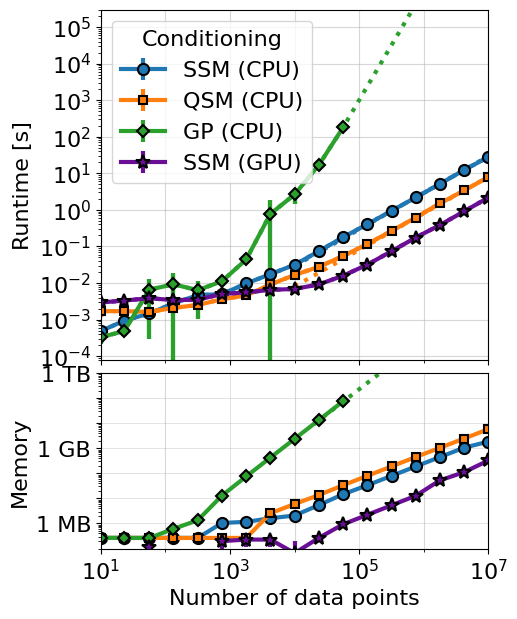

In [ ]:
fig, (ax1, ax2) = benchmark_plot(Ns, runtime_cond, memory_cond, 
                                 title='Conditioning', 
                                 labels={"SSM": "SSM (CPU)", 
                                         "QSM": "QSM (CPU)", 
                                         "GP": "GP (CPU)", 
                                         "pSSM": "SSM (GPU)"})
Next = jnp.logspace(4,8,10)
ax1.plot(Next, scale_ext(Next, Ns, runtime_cond['SSM'], ref=-2, power=1), ls=':', color=colors['SSM'], label='O(N)')
ax1.plot(Next, scale_ext(Next, Ns, runtime_cond['QSM'], ref=-2, power=1), ls=':', color=colors['QSM'], label='O(N)')
ax1.set_ylim(top=3e5);

Next = jnp.logspace(4.3,8,10)
ax2.plot(Next, scale_ext(Next, Ns, memory_cond['GP'], ref=5, power=2), ls=':', color=colors['GP'], label='O(N^2)');
ax2.set_yticks([1e6, 1e7, 1e8, 1e9, 1e10, 1e11, 1e12], labels=['1 MB', '', '', '1 GB', '', '', '1 TB']); ax2.set_ylabel('Memory')
ax2.grid(lw=0.5, zorder=-1, which='major')
ax2.set_ylim(bottom=1e5, top=1e12);

ax1.annotate("$N^3$", xy=(3e5, 2e6), color=colors['GP'], ha='left', va='top', xycoords='data', fontsize=16)
ax2.annotate("$N^2$", xy=(1.2e5, 2e11), color=colors['GP'], ha='left', va='top', xycoords='data', fontsize=16)

# ax2.set_xlim(right=5e5);

In [55]:
def getloc(out):
    try:
        mean = out[0]
        return mean[0]
    except:
        return jnp.nan

def getvar(out):
    try:
        var = out[1] - jnp.median(out[1])
        return var[0]
    except:
        return jnp.nan

In [56]:
means = {name: [getloc(outputs_cond[name][n]) for n in range(len(Ns))] for name in outputs_cond}
vars  = {name: [getvar(outputs_cond[name][n]) for n in range(len(Ns))] for name in outputs_cond}

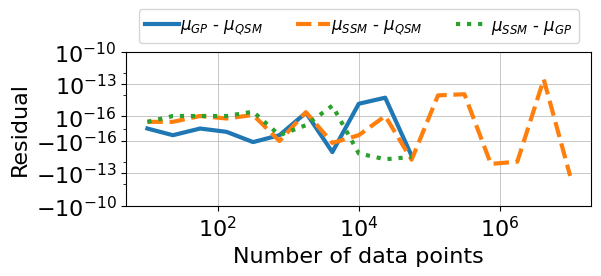

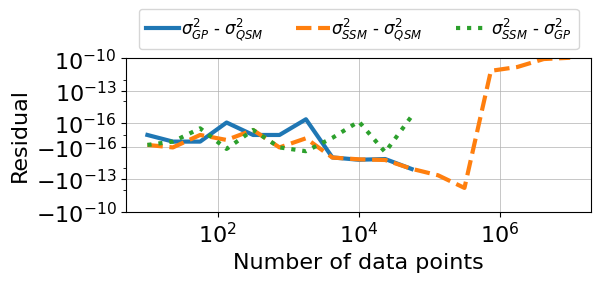

In [57]:
fig, rax = residuals_plot(Ns, means, label=r'\mu')
fig, rax = residuals_plot(Ns, vars, label=r'\sigma^2')

# Prediction

In [58]:
cpu_cond_filename = 'results/cpu_pred_benchmark.pkl'
# gpu_cond_filename = 'results/gpu_cond_benchmark.pkl'

# cpu_pred = load_from_individual('pred')
cpu_pred = load_benchmark_data(cpu_cond_filename)
# gpu_pred = load_benchmark_data(gpu_cond_filename)

In [59]:
## Merge the CPU and GPU benchmark results
pred = {key: cpu_pred[key] for key in cpu_pred} # quick copy

# for d in ['runtime', 'memory']:
# # for d in ['runtime']:
#     cond[d]['pSSM'] = gpu_cond[d]['pSSM']
Ns, runtime_pred, memory_pred, outputs_pred = pred['Ns'], pred['runtime'], pred['memory'], pred['outputs']

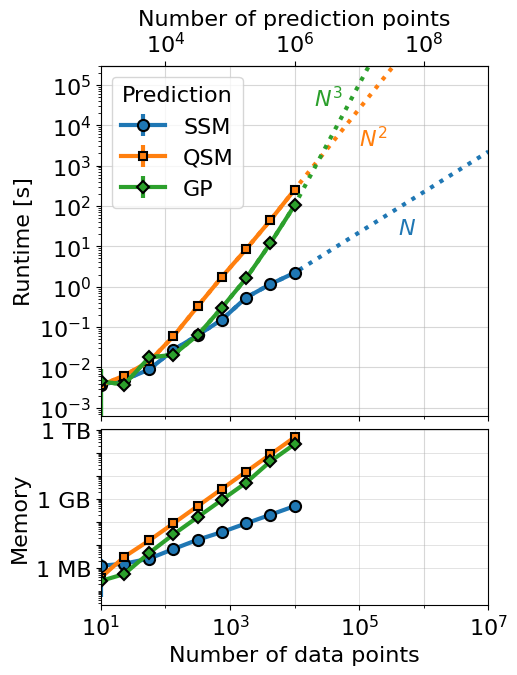

In [76]:
fig, (ax1, ax2) = benchmark_plot(Ns, runtime_pred, memory_pred, title='Prediction',
                                 powers={"SSM": 1, "QSM": 2, "GP": 3},)
Next = jnp.logspace(4,8,10)
# ax1.plot(Next, scale_ext(Next, Ns, runtime_pred['SSM'], ref=-2, power=1), ls=':', color=colors['SSM'], label='O(N)')
# ax1.plot(Next, scale_ext(Next, Ns, runtime_pred['QSM'], ref=-2, power=1), ls=':', color=colors['QSM'], label='O(N)')
ax1.set_ylim(top=3e5);
def forward(x):
    return 100 * x
def inverse(x):
    return x / 100
ax_top = ax1.secondary_xaxis('top', functions=(forward, inverse))
ax_top.set_xlabel("Number of prediction points")
ax1.annotate("$N$",   xy=(4e5, 5e1), color=colors['SSM'], ha='left', va='top', xycoords='data', fontsize=16)
ax1.annotate("$N^2$", xy=(1e5, 1e4), color=colors['QSM'], ha='left', va='top', xycoords='data', fontsize=16)
ax1.annotate("$N^3$", xy=(2e4, 1e5), color=colors['GP'], ha='left', va='top', xycoords='data', fontsize=16)

Next = jnp.logspace(4.3,8,10)
# ax2.plot(Next, scale_ext(Next, Ns, memory_pred['GP'], ref=5, power=2), ls=':', color=colors['GP'], label='O(N^2)');
ax2.set_yticks([1e6, 1e7, 1e8, 1e9, 1e10, 1e11, 1e12], labels=['1 MB', '', '', '1 GB', '', '', '1 TB']); ax2.set_ylabel('Memory')
ax2.grid(lw=0.5, zorder=-1, which='major')
# ax2.set_ylim(bottom=1e5, top=1e12);

# ax2.set_xlim(right=5e5);